In [7]:
import matplotlib.pyplot as plt
# The line below allows to print all the outputs of a cell instead of only the last one
%config InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import os
import pandas as pd
# noinspection PyPackageRequirements
# noinspection PyPackageRequirements
import seaborn as sns
import sys
# noinspection PyPackageRequirements

import yaml

import pickle
import pathlib

In [9]:
from_script = False

print(f"WARNING: This notebook is set with from_script = {from_script}.")

if from_script:
    # Get the path of the notebook config file from the environment variable
    path_config_notebook = os.environ["PATH_YAML_CONFIG"]
    # Load the notebook config file
    with open(path_config_notebook, "r") as file:
        dict_config_notebook = yaml.safe_load(file)
    id_xp = dict_config_notebook["id_xp"]
    path_project = pathlib.Path(dict_config_notebook["path_project"])
else:
    id_xp = 24
    path_project = pathlib.Path("/home/hosseinkhan/Documents/work/phd/git_repositories/doe4rl")

# Add the path of the project to the sys.path in order to import the modules in the src folder
sys.path.insert(0, os.path.abspath(path_project))

# Define the paths
path_mlruns = pathlib.Path(f"{path_project}/experiments/mlruns")
path_experiment = pathlib.Path(f"{path_mlruns}/{id_xp}")
# Get all folder in the mlruns/id_xp directory except the folder 'tags' using pathlib and iter dir
list_id_hash = [path.name for path in path_experiment.iterdir() if path.is_dir() and path.name != "tags"]

print(f"Number of runs: {len(list_id_hash)} \n")
print(f"XP id: {id_xp} \n")

nested_dict_config = {}
list_df_config_flattened = []
# Verify all experiments are done on the same environment:
path_xp = f"{path_mlruns}/{id_xp}"
for name_id in list_id_hash:
    list_glob_config = list(pathlib.Path(f"{path_xp}/{name_id}/artifacts/hydra_config").glob("./*/.hydra/config.yaml"))
    assert len(list_glob_config) == 1, "More than one config file in the directory."

    name_config_file = list_glob_config[0].name
    # Check if the file is a yaml file
    assert name_config_file.endswith(".yaml"), "File is not a yaml file."

    path_run_config_yaml = list_glob_config[0]
    with open(path_run_config_yaml, "r") as file:
        # Get the config file as a dictionary
        dict_config_temp = yaml.safe_load(file)
        # Add the config file to the nested dictionary
        nested_dict_config[name_id] = dict_config_temp
        # Flatten the config file for easier check
        list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))
    del dict_config_temp

# Check afterwards if all the configurations are the same
set_expected_nonunique_keys = {"alg_num_iters",
                               "crop_to_domain",
                               "project_to_domain",
                               "alg_n_semimarkov_dt",
                               "seed",
                               "name"}

set_nonunique_keys = set(pd.concat(list_df_config_flattened)
                         .astype(str)
                         .nunique()
                         .loc[lambda x: x > 1]
                         .to_dict()
                         .keys())

print(f"Set of non unique keys: {set_nonunique_keys} \n")

# Check if the configurations are the same inter runs
bool_similar_configs = set_nonunique_keys.issubset(set_expected_nonunique_keys)
assert bool_similar_configs, "The configurations are not the same."

# Pretty print the first config file
print(f"First config file: {list_id_hash[0]} \n")
print(yaml.dump(nested_dict_config[list_id_hash[0]], sort_keys=False))

Number of runs: 40 

XP id: 24 
Set of non unique keys: {'seed', 'alg_n_semimarkov_dt'} 

First config file: ca02597373d846babbdc714a62398e43 

name: debug
num_eval_trials: 5
eval_frequency: 2
resume: false
env:
  teleport: false
  normalize_env: true
  sample_exe: false
  gp:
    periodic: false
    opt_max_iter: 10
    ls:
    - - 0.17
      - 2.08
      - 7.16
      - 82.55
      - 42.86
      - 13.4
    - - 0.26
      - 1.61
      - 2.09
      - 84.71
      - 94.44
      - 91.4
    - - 0.09
      - 2.53
      - 0.72
      - 87.77
      - 35.5
      - 79.94
    alpha:
    - 12.23
    - 10.14
    - 6.57
    sigma: 0.0011
  tf_precision: 64
  name: lorenz-new-v0
  mpc:
    nsamps: 25
    planning_horizon: 2
    n_elites: 1
    beta: 3
    gamma: 1.25
    xi: 0.3
    num_iters: 1
    actions_per_plan: 1
  eigmpc:
    nsamps: 25
    planning_horizon: 2
    n_elites: 1
    beta: 3
    gamma: 1.25
    xi: 0.3
    num_iters: 1
    actions_per_plan: 1
  environment_parameters:
    dict_pde_

In [12]:
(pd.concat(list_df_config_flattened, keys=list_id_hash)
 .astype(str)
 # .groupby(["seed", "alg_n_semimarkov_dt"])
 # .loc[:, ["alg_num_iters", "crop_to_domain", "project_to_domain", "alg_n_semimarkov_dt", "seed", "name"]]
 .loc[:, ["alg_num_iters", "alg_n_semimarkov_dt", "seed", "name"]]
 .nunique()

 )

alg_num_iters           1
alg_n_semimarkov_dt     4
seed                   10
name                    1
dtype: int64

In [4]:
list_name_columns_learning = ["Acquisition Function Value",
                              "Eval Returns",
                              "Eval ndata",
                              "mean_difference_state_boostrap",
                              "n_corresponding_dt",
                              "Model MSE (current real MPC)",
                              "Model MSE (random test set)",
                              "Model MSE (GT MPC)",
                              "Model Likelihood (random test set)",
                              "Model Likelihood (GT MPC)", ]

dict_columns_learning_renaming_map = {"Acquisition Function Value": "eig",
                                      "Eval Returns": "eval_returns",
                                      "Eval ndata": "eval_ndata",
                                      "mean_difference_state_boostrap": "mean_difference_state_bootstrap",
                                      "Model MSE (current real MPC)": "model_mse_current_real_mpc",
                                      "Model MSE (random test set)": "model_mse_random_test_set",
                                      "Model MSE (GT MPC)": "model_mse_gt_mpc",
                                      "Model Likelihood (random test set)": "model_likelihood_random_test_set",
                                      "Model Likelihood (GT MPC)": "model_likelihood_gt_mpc", }

# Load each of the runs data
list_df_learning_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"
    # list(path_experiment.iterdir())[0]

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)
    # nested_dict_config[name_id]["eval_frequency"] * (len(dict_data["x"]) - 1) + (len(dict_data["x"]) - 1) % nested_dict_config[name_id]["eval_frequency"]
    
    list_array = []
    eval_frequency = nested_dict_config[name_id]["eval_frequency"]
    
    list_excluded_columns_reshape = ["Acquisition Function Value", "mean_difference_state_boostrap", "n_corresponding_dt"]
    
    # Reshape array to have the same length as the number of iterations
    dict_temp = {name_column: list(dict_data[name_column][:1]) + list(np.repeat(dict_data[name_column][1:], eval_frequency, axis=0))[:-((len(dict_data["x"])) % eval_frequency)]
                 for name_column in list_name_columns_learning if name_column not in list_excluded_columns_reshape}
    # Add the excluded columns without reshaping
    dict_temp.update({name_column: dict_data[name_column] for name_column in list_excluded_columns_reshape})
    df_learning_data_temp = (
        pd.DataFrame(dict_temp)
        .explode("Eval Returns")
        .reset_index(names=["iteration"])
        .rename(columns=dict_columns_learning_renaming_map)
    )

    list_df_learning_data.append(df_learning_data_temp)

In [5]:
tst = {name_column: list(dict_data[name_column][:1]) + list(np.repeat(dict_data[name_column][1:], eval_frequency, axis=0))[:-((len(dict_data["x"])) % eval_frequency)]
 for name_column in list_name_columns_learning if name_column not in list_excluded_columns_reshape}

In [6]:
# Get the list of the delay mode
list_action_delay_mode = [nested_dict_config[name_id]["alg"]["n_semimarkov_dt"]
                          for name_id in list_id_hash]

list_keys_tuple_id_action_delay_mode = [(run_id, action_delay_mode)
                                        for run_id, action_delay_mode
                                        in zip(list_id_hash, list_action_delay_mode)]

df_learning_data = pd.concat(list_df_learning_data, keys=list_keys_tuple_id_action_delay_mode,
                             names=["run_id", "action_delay_mode"])

In [7]:
df_learning_data.describe()

,iteration,eval_ndata,model_mse_current_real_mpc,model_mse_random_test_set,model_mse_gt_mpc,model_likelihood_random_test_set,model_likelihood_gt_mpc,eig,mean_difference_state_bootstrap,n_corresponding_dt
count,40000.000000,40000.000000,4.000000e+04,40000.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,4.000000e+04,40000.00000
mean,99.500000,100.995000,7.329604e-04,50.580184,4.418789e-04,-5.666051,-2.757132,2.595609,7.206663e-03,2.36975
std,57.735027,57.732905,1.665503e-03,5.080747,1.291427e-03,0.260670,0.000559,0.919341,2.947854e-02,1.88663
min,0.000000,1.000000,4.311491e-09,41.228044,8.262073e-09,-6.260964,-2.763149,0.500648,0.000000e+00,1.00000
25%,49.750000,51.000000,4.666193e-07,46.870602,3.318121e-07,-5.864576,-2.757140,1.849065,2.775558e-17,1.00000
50%,99.500000,101.000000,1.171778e-04,50.074299,3.545967e-05,-5.634932,-2.756920,2.545490,1.236777e-04,2.00000
75%,149.250000,151.000000,7.109026e-04,53.895987,3.025395e-04,-5.485671,-2.756834,3.218988,1.323910e-03,3.00000
max,199.000000,200.000000,2.664696e-02,62.329026,2.205879e-02,-5.216473,-2.756819,6.594208,4.839206e-01,8.00000


In [8]:
n_eval_trajectory = nested_dict_config[list_id_hash[0]]["num_eval_trials"]

(df_learning_data
 .reset_index(level=-1)
 .assign(trajectory_id=lambda df: df["level_2"] % n_eval_trajectory)
 .drop(columns=["level_2"]))

iteration   eval_returns  \
run_id                           action_delay_mode                             
0451918845904d82976880025961c9f9 2                          0 -283832.725733   
                                 2                          0 -282786.619312   
                                 2                          0 -282541.721339   
                                 2                          0 -280825.758757   
                                 2                          0 -283185.713256   
...                                                       ...            ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 1                        199 -150483.039324   
                                 1                        199  -96608.415603   
                                 1                        199 -151614.314298   
                                 1                        199 -219554.768314   
                                 1                        199 -167379.661669   

                                                    eval_ndata  \
run_id                           action_delay_mode               
0451918845904d82976880025961c9f9 2                         1.0   
                                 2                         1.0   
                                 2                         1.0   
                                 2                         1.0   
                                 2                         1.0   
...                                                        ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 1                       200.0   
                                 1                       200.0   
                                 1                       200.0   
                                 1                       200.0   
                                 1                       200.0   

                                                    model_mse_current_real_mpc  \
run_id                           action_delay_mode                               
0451918845904d82976880025961c9f9 2                                3.055810e-04   
                                 2                                3.055810e-04   
                                 2                                3.055810e-04   
                                 2                                3.055810e-04   
                                 2                                3.055810e-04   
...                                                                        ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 1                                6.102041e-08   
                                 1                                6.102041e-08   
                                 1                                6.102041e-08   
                                 1                                6.102041e-08   
                                 1                                6.102041e-08   

                                                    model_mse_random_test_set  \
run_id                           action_delay_mode                              
0451918845904d82976880025961c9f9 2                                  52.584110   
                                 2                                  52.584110   
                                 2                                  52.584110   
                                 2                                  52.584110   
                                 2                                  52.584110   
...                                                                       ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 1                                  53.218719   
                                 1                                  53.218719   
                                 1                                  53.218719   
                                 1                                  53.218719   
                                 1                                  53.218719   

                               

In [9]:
(df_learning_data
 .reset_index(level=-1)
 .assign(trajectory_id=lambda df: df["level_2"] % n_eval_trajectory)
 .drop(columns=["level_2"])
 .reset_index()
 .groupby(["trajectory_id", "action_delay_mode", "run_id"])
 .rolling(window=10, min_periods=1)
 .mean()
 .reset_index()
 )

,trajectory_id,action_delay_mode,run_id,level_3,iteration,eval_returns,eval_ndata,model_mse_current_real_mpc,model_mse_random_test_set,model_mse_gt_mpc,model_likelihood_random_test_set,model_likelihood_gt_mpc,eig,mean_difference_state_bootstrap,n_corresponding_dt
0,0,1,117c7791ccd1464b9b97799c8f280d38,26000,0.0,-279178.240882,1.000000,5.151796e-04,43.876760,1.720063e-03,-5.216887,-2.757198,3.072266,0.078435,2.000000
1,0,1,117c7791ccd1464b9b97799c8f280d38,26005,0.5,-268318.979610,2.000000,5.758901e-03,43.854952,4.338230e-03,-5.216834,-2.757592,2.909100,0.078146,2.000000
2,0,1,117c7791ccd1464b9b97799c8f280d38,26010,1.0,-264699.225852,2.333333,7.506808e-03,43.847683,5.210952e-03,-5.216817,-2.757724,2.940896,0.052098,1.666667
3,0,1,117c7791ccd1464b9b97799c8f280d38,26015,1.5,-259894.712322,3.000000,7.829725e-03,43.846176,5.239000e-03,-5.218604,-2.757949,3.171033,0.045469,1.750000
4,0,1,117c7791ccd1464b9b97799c8f280d38,26020,2.0,-257012.004203,3.400000,8.023476e-03,43.845272,5.255829e-03,-5.219676,-2.758084,3.211562,0.036375,1.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,4,8,fe78d71e5114441dbc54b02ab03614db,9979,190.5,-174740.991458,192.000000,1.649868e-08,41.790446,6.347998e-08,-5.316653,-2.756825,1.336764,0.001369,5.100000
39996,4,8,fe78d71e5114441dbc54b02ab03614db,9984,191.5,-179493.670361,193.000000,1.582816e-08,41.790655,6.264405e-08,-5.316876,-2.756825,1.362647,0.001186,4.400000
39997,4,8,fe78d71e5114441dbc54b02ab03614db,9989,192.5,-181827.499990,194.000000,1.523601e-08,41.791321,6.147424e-08,-5.317092,-2.756825,1.331589,0.001114,3.900000
39998,4,8,fe78d71e5114441dbc54b02ab03614db,9994,193.5,-184161.329620,195.000000,1.464385e-08,41.791988,6.030444e-08,-5.317308,-2.756825,1.363551,0.001110,4.200000


##### Plotting metrics from pickle data

================== eig ==================


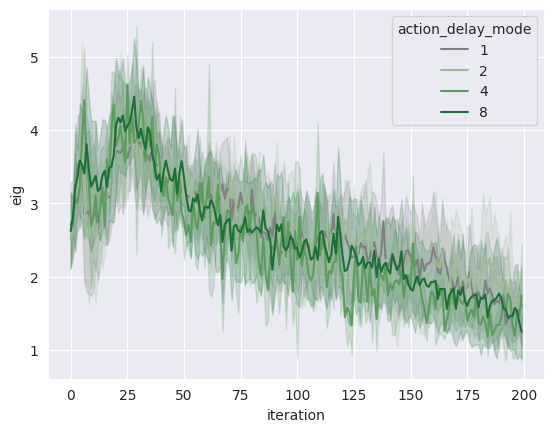

================== eval_returns ==================


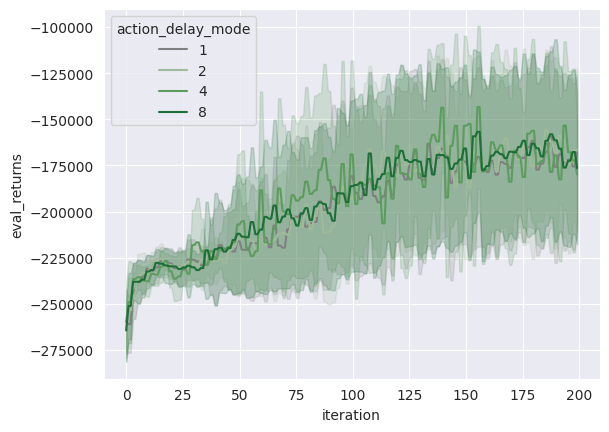

================== mean_difference_state_bootstrap ==================


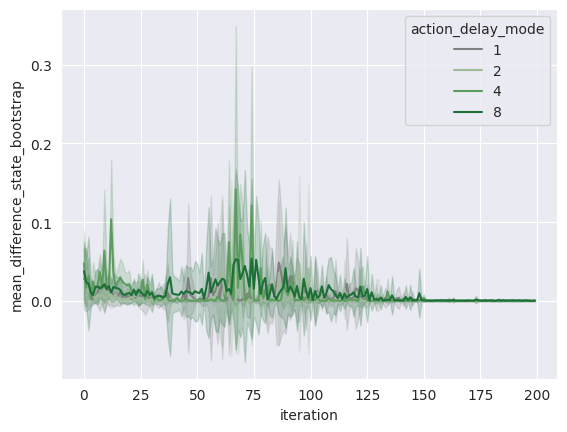

================== n_corresponding_dt ==================


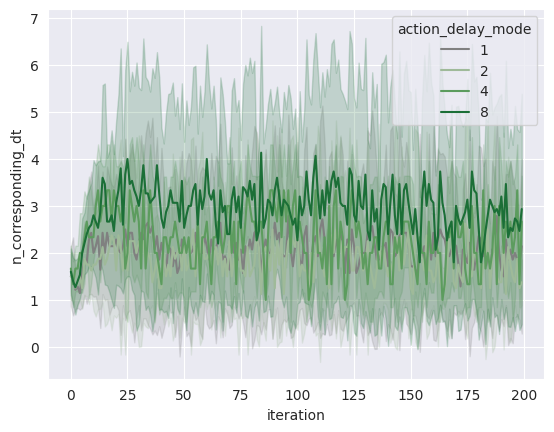

================== model_mse_current_real_mpc ==================


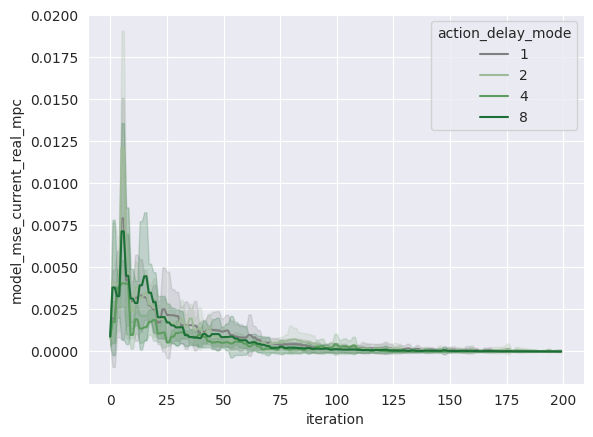

================== model_mse_random_test_set ==================


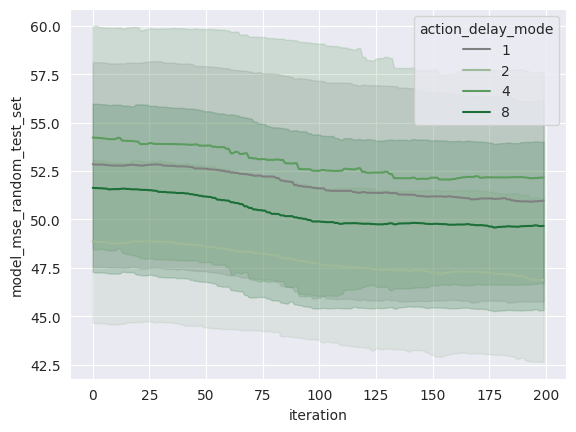

================== model_mse_gt_mpc ==================


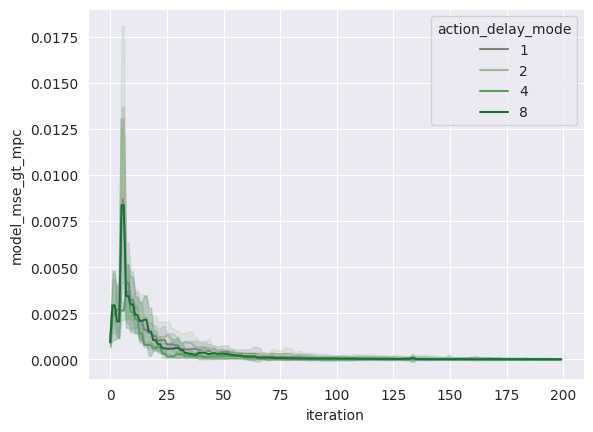

================== model_likelihood_random_test_set ==================


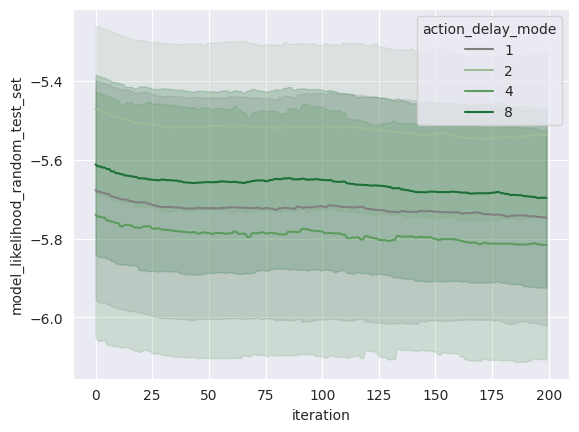

================== model_likelihood_gt_mpc ==================


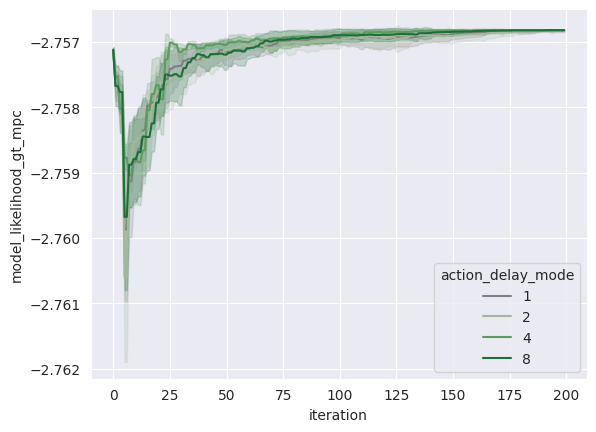

================== eval_ndata ==================


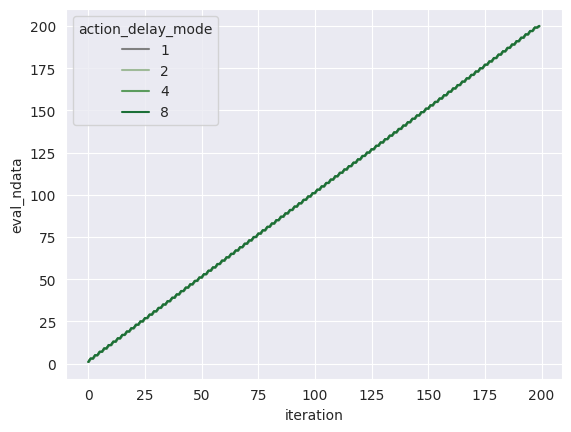

In [10]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Greens", len(set(list_action_delay_mode)) - 1)
# Increase darkness of all colors in palette
coeff_darkness = 0.8
sns_other_palette = sns.color_palette([tuple(coeff_darkness * np.array(color)) for color in sns_other_palette])
list_color_palette = ["Grey"] + sns_other_palette
# list_color_palette = ["black"] + sns.color_palette("Greens", len(list_action_delay_mode) - 1).as_hex()
df_plot = df_learning_data.reset_index()

list_columns_plot = ["eig", "eval_returns", "mean_difference_state_bootstrap", "n_corresponding_dt",
                     "model_mse_current_real_mpc", "model_mse_random_test_set",
                     "model_mse_gt_mpc", "model_likelihood_random_test_set", "model_likelihood_gt_mpc", "eval_ndata"]

plt.close()
for name_column in list_columns_plot:
    print(f"================== {name_column} ==================")
    g = sns.lineplot(data=df_plot,
                     x="iteration",
                     y=name_column,
                     hue="action_delay_mode",
                     errorbar="sd",
                     legend="full",
                     palette=list_color_palette)
    plt.show()
    # Save the   figure
    # g.figure.savefig(f"/home/hosseinkhan/Downloads/temp_imgs/{name_column}.png")
    # plt.close()

##### Moving average of the eval returns

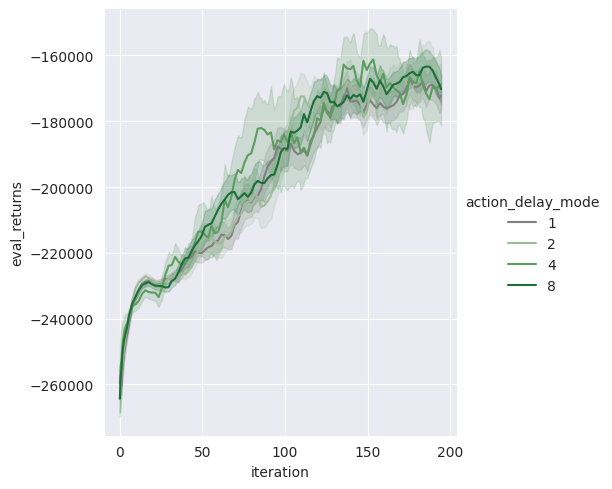

In [26]:
df_plot = (df_learning_data
           .reset_index(level=-1)
           .assign(trajectory_id=lambda df: df["level_2"] % n_eval_trajectory)
           .drop(columns=["level_2"])
           .reset_index()
           .groupby(["trajectory_id", "action_delay_mode", "run_id"])
           .rolling(window=10   , min_periods=1)
           .mean()
           .reset_index()
           )

# Seaborn lineplot of eval returns
sns.relplot(data=df_plot,
            x="iteration",
            y="eval_returns",
            hue="action_delay_mode",
            # col="trajectory_id",
            kind="line",
            # no sharing of y axis rowwise
            facet_kws=dict(sharey=False),
            # reduce size of markers
            palette=list_color_palette,
            # s=3, 
            )

In [12]:
dim_x = len(nested_dict_config[list_id_hash[0]]["env"]["gp"]["alpha"])
dim_u = len(nested_dict_config[list_id_hash[0]]["env"]["gp"]["ls"][0]) - dim_x

list_df_trajectory_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)

    df_trajectory_data_temp = (pd.concat(
        [pd.DataFrame(np.array(dict_data["x"])[:, :dim_x]), pd.DataFrame(np.array(dict_data["x"])[:, dim_x:])],
        axis="columns",
        keys=["state", "action"],
        names=["component", "i"]).assign(n_corresponding_dt=[0] + list(np.array(dict_data["n_corresponding_dt"])),
                                         iteration=[0] + list(np.array(dict_data["n_corresponding_dt"]).cumsum())
                                         )
                               )

    list_df_trajectory_data.append(df_trajectory_data_temp)

In [13]:
df_trajectory_data = pd.concat(list_df_trajectory_data, keys=list_keys_tuple_id_action_delay_mode,
                               names=["run_id", "action_delay_mode"])

In [14]:
df_trajectory_data

component                                                  state            \
i                                                              0         1   
run_id                           action_delay_mode                           
0451918845904d82976880025961c9f9 2                 0   -0.085293 -0.085208   
                                                   1   -0.086326 -0.084709   
                                                   2   -0.081714 -0.082314   
                                                   3   -0.080768 -0.082359   
                                                   4   -0.079360 -0.081049   
...                                                          ...       ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 1                 196 -0.049634  0.059024   
                                                   197  0.031145  0.051363   
                                                   198  0.104136  0.151325   
                                                   199  0.142936  0.135419   
                                                   200  0.073978  0.018090   

component                                                           action  \
i                                                              2         0   
run_id                           action_delay_mode                           
0451918845904d82976880025961c9f9 2                 0    0.268951 -0.699207   
                                                   1    0.272007  0.859469   
                                                   2    0.267326  0.292849   
                                                   3    0.263322  0.433625   
                                                   4    0.257910 -0.953253   
...                                                          ...       ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 1                 196  0.330276 -0.580295   
                                                   197  0.210281  0.185241   
                                                   198  0.213525  0.901775   
                                                   199  0.339936  0.688693   
                                                   200  0.302205  0.916770   

component                                                                   \
i                                                              1         2   
run_id                           action_delay_mode                           
0451918845904d82976880025961c9f9 2                 0    0.974182  0.597786   
                                                   1    0.499549 -0.724050   
                                                   2    0.363205 -0.389767   
                                                   3    0.996104 -0.645301   
                                                   4    0.598660 -0.927744   
...                                                          ...       ...   
8bb8119b4b4944589c4ea9b9b3ec1c61 1                 196 -0.465290 -0.939533   
                                                   197 -0.887547 -0.977188   
                                                   198  0.795797 -0.862159   
                                                   199 -0.719531 -0.350155   
                                                   200  0.888174 -0.965057   

component                                              n_corresponding_dt  \
i                                                                           
run_id                           action_delay_mode                          
0451918845904d82976880025961c9f9 2                 0                  0.0   
                                                   1                  1.0   
                                                   2                  1.0   
                                                   3                  1.0   
                                                   4                  1.0   
...                                                                   ...   
8bb8119b4b4944589c4ea9b9b3ec

In [15]:
df_trajectory_data.describe()

component        state                                 action               \
i                    0            1            2            0            1   
count      8040.000000  8040.000000  8040.000000  8040.000000  8040.000000   
mean         -0.038555    -0.040361     0.239520     0.220801     0.274639   
std           0.076205     0.087184     0.086060     0.658094     0.679998   
min          -0.188294    -0.264895    -0.000965    -0.999921    -0.999680   
25%          -0.090378    -0.095886     0.182102    -0.425319    -0.383056   
50%          -0.060890    -0.056650     0.248864     0.471448     0.593862   
75%           0.001743     0.004991     0.293836     0.808698     0.863057   
max           0.190047     0.266100     0.483821     0.999740     0.999975   

component              n_corresponding_dt    iteration  
i                    2                                  
count      8040.000000        8040.000000  8040.000000  
mean         -0.577391           2.357960   238.185697  
std           0.551499           1.889397   200.319426  
min          -0.999989           0.000000     0.000000  
25%          -0.940136           1.000000    88.000000  
50%          -0.846922           2.000000   179.000000  
75%          -0.442171           3.000000   329.000000  
max           0.999970           8.000000   938.000000

In [16]:
df_trajectory_data["state", 0] *= 80
df_trajectory_data["state", 1] *= 8

df_trajectory_data["action", 0] *= 2


In [17]:
df_trajectory_data.describe()

component        state                                 action               \
i                    0            1            2            0            1   
count      8040.000000  8040.000000  8040.000000  8040.000000  8040.000000   
mean         -3.084431    -0.322888     0.239520     0.441602     0.274639   
std           6.096391     0.697471     0.086060     1.316188     0.679998   
min         -15.063500    -2.119164    -0.000965    -1.999843    -0.999680   
25%          -7.230235    -0.767092     0.182102    -0.850639    -0.383056   
50%          -4.871164    -0.453200     0.248864     0.942896     0.593862   
75%           0.139401     0.039931     0.293836     1.617397     0.863057   
max          15.203760     2.128797     0.483821     1.999479     0.999975   

component              n_corresponding_dt    iteration  
i                    2                                  
count      8040.000000        8040.000000  8040.000000  
mean         -0.577391           2.357960   238.185697  
std           0.551499           1.889397   200.319426  
min          -0.999989           0.000000     0.000000  
25%          -0.940136           1.000000    88.000000  
50%          -0.846922           2.000000   179.000000  
75%          -0.442171           3.000000   329.000000  
max           0.999970           8.000000   938.000000

In [18]:
(df_trajectory_data
 .set_index(["n_corresponding_dt", "iteration"], append=True)
 .stack(level=["component", "i"])
 .rename("system_value")
 .reset_index()
 .drop(columns="level_2"))

,run_id,action_delay_mode,n_corresponding_dt,iteration,component,i,system_value
0,0451918845904d82976880025961c9f9,2,0.0,0.0,action,0,-1.398414
1,0451918845904d82976880025961c9f9,2,0.0,0.0,action,1,0.974182
2,0451918845904d82976880025961c9f9,2,0.0,0.0,action,2,0.597786
3,0451918845904d82976880025961c9f9,2,0.0,0.0,state,0,-6.823453
4,0451918845904d82976880025961c9f9,2,0.0,0.0,state,1,-0.681665
...,...,...,...,...,...,...,...
48235,8bb8119b4b4944589c4ea9b9b3ec1c61,1,3.0,547.0,action,1,0.888174
48236,8bb8119b4b4944589c4ea9b9b3ec1c61,1,3.0,547.0,action,2,-0.965057
48237,8bb8119b4b4944589c4ea9b9b3ec1c61,1,3.0,547.0,state,0,5.918223
48238,8bb8119b4b4944589c4ea9b9b3ec1c61,1,3.0,547.0,state,1,0.144717


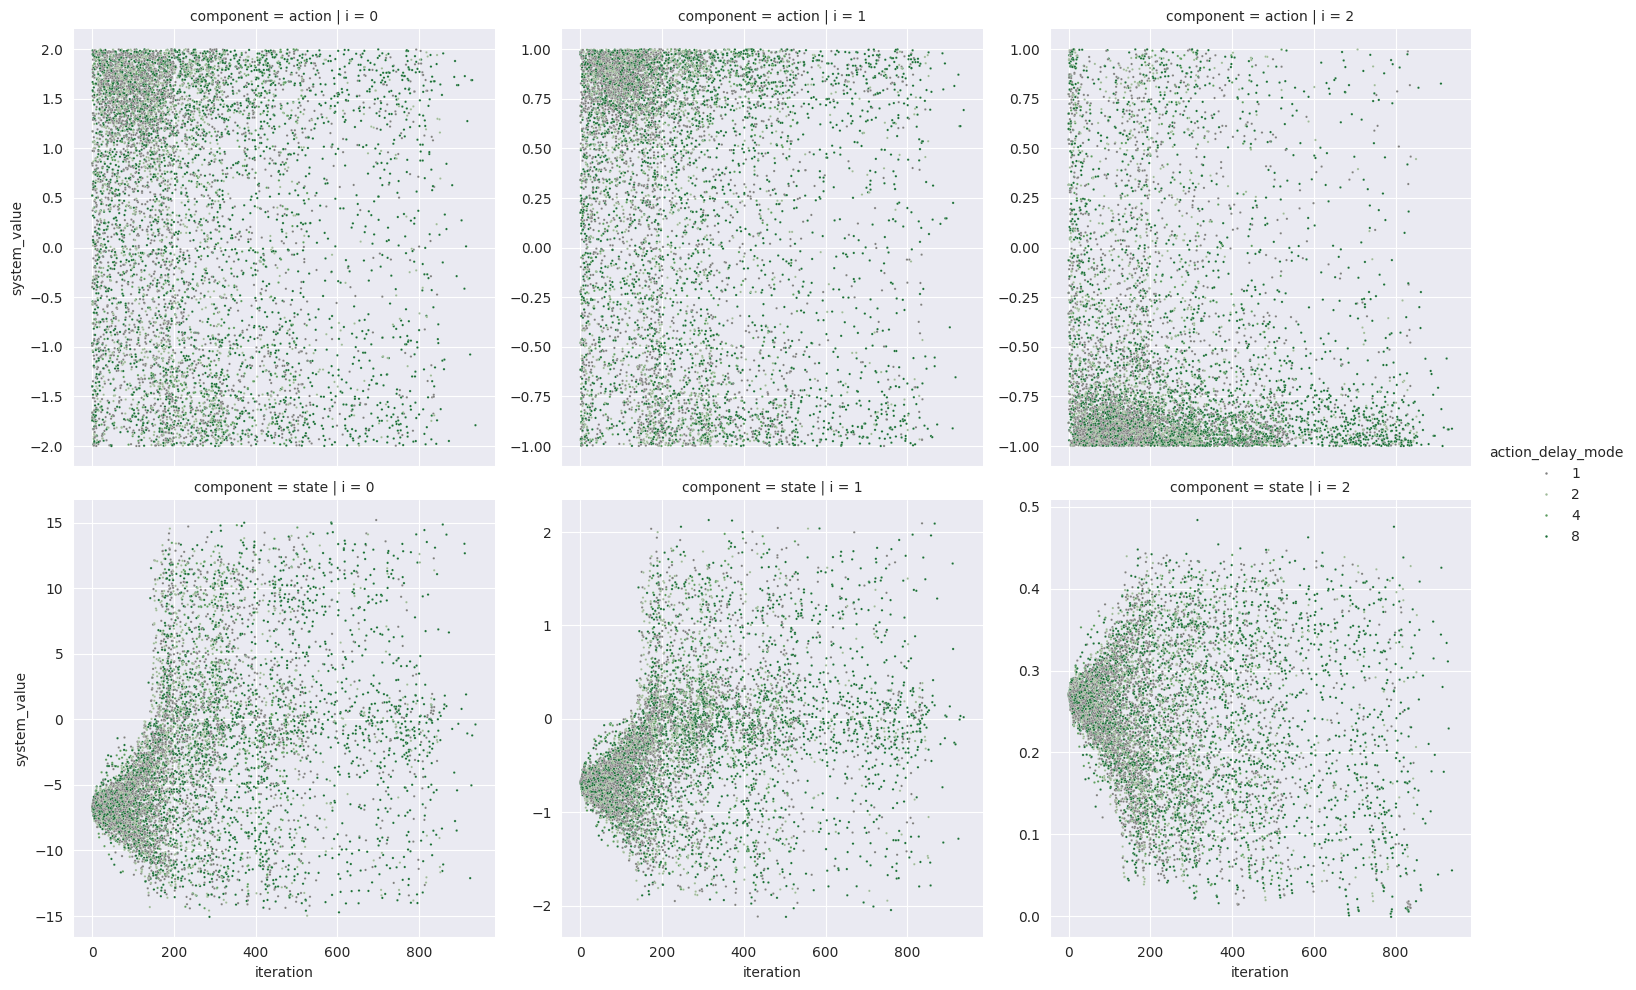

In [19]:
df_temp = (df_trajectory_data
           .set_index(["n_corresponding_dt", "iteration"], append=True)
           .stack(level=["component", "i"])
           .rename("system_value")
           .reset_index()
           .drop(columns="level_2"))

sns.relplot(data=df_temp,
            x="iteration",
            y="system_value",
            hue="action_delay_mode",
            col="i",
            row="component",
            # kind="line",
            # no sharing of y axis rowwise
            facet_kws=dict(sharey=False),
            # reduce size of markers
            palette=list_color_palette,
            s=3, )

##### Action distribution along time

/tmp/ipykernel_164615/1998059645.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_temp = (df_trajectory_data


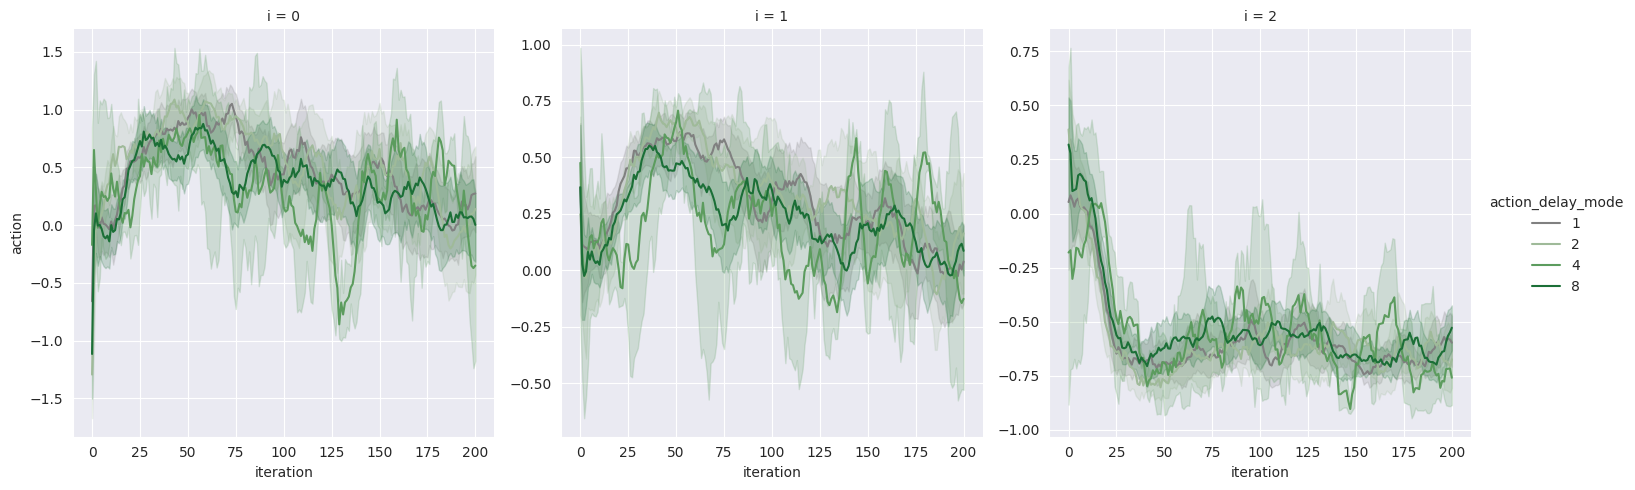

In [20]:
window_size = 10
df_temp = (df_trajectory_data
           .loc[pd.IndexSlice[:, :, :], ["action"]]
           .groupby(["run_id", "action_delay_mode"], as_index=False)
           .rolling(window=window_size, min_periods=1)
           .mean()
           .drop(columns=["run_id", "action_delay_mode"])
           .stack(level=-1)
           .reset_index()
           .rename(columns={"level_2": "iteration"}))

# Plot the time series
sns.relplot(data=df_temp,
            x="iteration",
            y="action",
            hue="action_delay_mode",
            col="i",
            kind="line",
            # no sharing of y axis rowwise
            facet_kws=dict(sharey=False),
            # reduce size of markers
            palette=list_color_palette,
            # s=3,
            )

In [21]:
(df_trajectory_data
 .set_index(["n_corresponding_dt", "iteration"], append=True)
 .stack(level=["component", "i"])
 .rename("system_value")
 .reset_index()
 .drop(columns="level_2"))

,run_id,action_delay_mode,n_corresponding_dt,iteration,component,i,system_value
0,0451918845904d82976880025961c9f9,2,0.0,0.0,action,0,-1.398414
1,0451918845904d82976880025961c9f9,2,0.0,0.0,action,1,0.974182
2,0451918845904d82976880025961c9f9,2,0.0,0.0,action,2,0.597786
3,0451918845904d82976880025961c9f9,2,0.0,0.0,state,0,-6.823453
4,0451918845904d82976880025961c9f9,2,0.0,0.0,state,1,-0.681665
...,...,...,...,...,...,...,...
48235,8bb8119b4b4944589c4ea9b9b3ec1c61,1,3.0,547.0,action,1,0.888174
48236,8bb8119b4b4944589c4ea9b9b3ec1c61,1,3.0,547.0,action,2,-0.965057
48237,8bb8119b4b4944589c4ea9b9b3ec1c61,1,3.0,547.0,state,0,5.918223
48238,8bb8119b4b4944589c4ea9b9b3ec1c61,1,3.0,547.0,state,1,0.144717


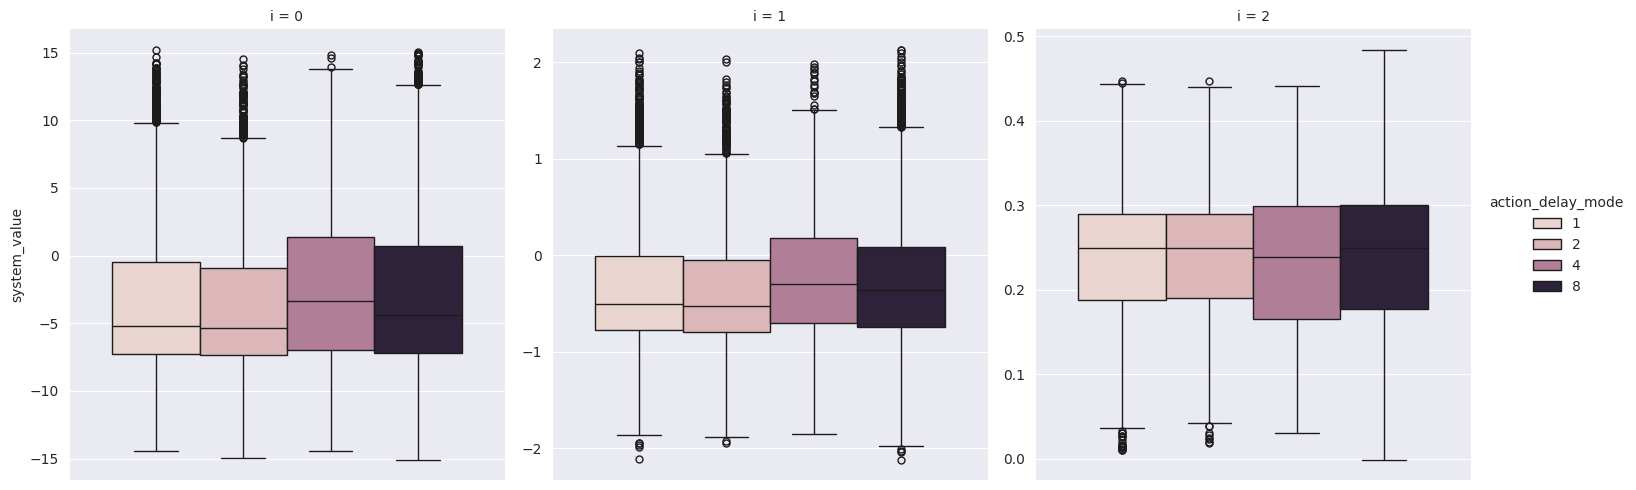

In [23]:
df_temp = (df_trajectory_data
.set_index(["n_corresponding_dt", "iteration"], append=True)
.stack(level=["component", "i"])
.rename("system_value")
.reset_index()
.drop(columns="level_2")
# Extract only the state
.loc[lambda df: df["component"] == "state"]
)

# Plot the statistics with boxplot
sns.catplot(data=df_temp,
            col="i",
            y="system_value",
            hue="action_delay_mode",
            # col="i",
            # col="component",
            # row="statistic",
            # kind="line",
            # no sharing of y axis rowwise
            sharey=False,
            # facet_kws=dict(sharey=False),
            # common_bins=False,
            kind="box",
            # bins=50
            # reduce size of markers
            # s=3,
            )